# Probabilistic Programming 3: Regression & Classification

#### Goal 
  - Understand how to estimate regression parameters using variational Bayesian inference.
  - Understand how to estimate classification parameters using variational Bayesian inference.
  
#### Materials       
  - Mandatory
    - This notebook.
    - Lecture notes on [regression](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Regression.ipynb).
    - Lecture notes on [generative](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Generative-Classification.ipynb) and discriminative [classification](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Discriminative-Classification.ipynb).
  - Optional
    - [Cheatsheets: how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

In [1]:
using Pkg
Pkg.activate("workspace")
Pkg.instantiate();
IJulia.clear_output();

## Problem: Economic growth

In 2008, the credit crisis sparked a recession in the US, which spread to other countries in the ensuing years. It took most countries a couple of years to recover. 
Now, the year is 2011. The Turkish government is asking you to estimate whether Turkey is out of the recession. You decide to look at the data of the national stock exchange to see if there's a positive trend. 

In [2]:
using CSV
using DataFrames
using Plots
pyplot();

### Data

We are going to start with loading in a data set. We have daily measurements from Istanbul, from the 5th of January 2009 until 22nd of February 2011. The dataset comes from an online resource for machine learning data sets: the [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE).

In [3]:
# Read CSV file
df = CSV.read("../datasets/istanbul_stockexchange.csv")

,date,ISE
,String,Float64
1,5-Jan-09,0.0357537
2,6-Jan-09,0.0254259
3,7-Jan-09,-0.0288617
4,8-Jan-09,-0.0622081
5,9-Jan-09,0.00985991
6,12-Jan-09,-0.029191
7,13-Jan-09,0.0154453
8,14-Jan-09,-0.0411676
9,15-Jan-09,0.000661905


We can plot the evolution of the stock market values over time.

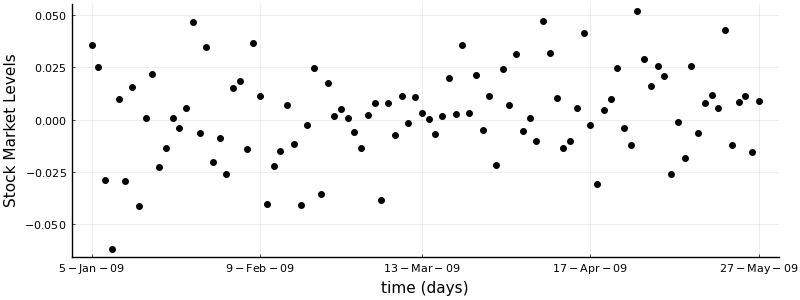

In [4]:
# Count number of samples
num_samples = 100

# Extract columns
dates_num = 1:num_samples
dates_str = df[1:num_samples,1]
stock_val = df[1:num_samples,2]

# Set xticks
xtick_points = Int64.(round.(range(1, stop=num_samples, length=5)))

# Scatter exchange levels
scatter(dates_num, 
        stock_val, 
        color="black",
        label="", 
        ylabel="Stock Market Levels", 
        xlabel="time (days)",
        xticks=(xtick_points, [dates_str[i] for i in xtick_points]), 
        size=(800,300))

### Model specification

We have dates $X$ and stock exchange levels $Y$. A regression model has parameters $\theta$, used to predict $Y$ from $X$. We are looking for a joint distribution that splits into a likelihood and prior distributions:

$$\underbrace{p(\theta \mid Y, X)}_{\text{posterior}} \propto\ \underbrace{p(Y \mid X, \theta)}_{\text{likelihood}} \cdot \underbrace{p(\theta)}_{\text{prior}}$$

We assume each observation $Y_i$ is generated via: 

$$ Y_i = f_\theta(X_i) + e$$ 

where $e$ is white noise, $e \sim \mathcal{N}(0, \sigma^2_Y)$, and the regression function $f_\theta$ is linear: $f_\theta(X) = X \theta_1 + \theta_2$. The parameters consist of a slope coefficient $\theta_1$ and an intercept $\theta_2$, which are summarized into a parameter vector, $\theta = [\theta_1\ \theta_2]$. We will use the name "covariates" for $X$ and "responses" for $Y$. If we integrate out the noise $e$, then we obtain a Gaussian likelihood function centered on $f_\theta(X)$ with variance $\sigma^2_Y$:

$$Y \sim \mathcal{N}(f_\theta(X),\sigma^2_Y)\, \ .$$ 

Note that this is the likelihood: $p(Y \mid X, \theta)$. We know that the weights are real numbers and that they can be negative. That motivates us to use a Gaussian prior:

$$ \theta \sim \mathcal{N}(\mu_\theta, \sigma^2_\theta) \, .$$

Note that this is $p(\theta)$. For now, this is all we need. We're going to specify these two equations with ForneyLab. First, we initialize a factor graph:

In [5]:
using ForneyLab

In [6]:
# Start factor graph
g = FactorGraph();

# Parameters for priors
μ_θ = [0., 0.]
σ2_θ = [1. 0.; 0. 1.]

# Fix noise
σ2_Y = 1.

# In ForneyLab we use the @RV macro to denote Random Variables
@RV X

# Define a prior over the weights
@RV θ ~ GaussianMeanVariance(μ_θ, σ2_θ)

# Response model is Gaussian function of the linear mapping between weights and covariates
@RV Y ~ GaussianMeanVariance(dot(X,θ), σ2_Y)

# Visualise the graph
ForneyLab.draw()

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 4877230228338362842 -->
 
 4877230228338362842 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 7059548890408786759 -->
 
 7059548890408786759 
 
 dot 
 dotproduct_1 
 
<!-- 4877230228338362842--7059548890408786759 -->
 
 4877230228338362842--7059548890408786759 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 4805238489438627492 -->
 
 4805238489438627492 
 
 clamp_3 
 
<!-- 4877230228338362842--4805238489438627492 -->
 
 4877230228338362842--4805238489438627492 
 
 clamp_3 
 1 out 
 3 v 
 
<!-- 5888483600926107653 -->
 
 5888483600926107653 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 7059548890408786759--5888483600926107653 -->
 
 7059548890408786759--5888483600926107653 
 
 θ 
 1 out 
 2 in1 
 
<!-- 12778978089307132597 -->
 
 12778978089307132597 
 
 clamp_2 
 
<!-- 5888483600926107653--12778978089307132597 -->
 
 5888483600926107653--12778978089307132597 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 3818311936302491143 -->
 
 3818311936302491143 
 
 clamp_1 
 
<!-- 5888483600926107653--3818311936302491143 -->
 
 5888483600926107653--3818311936302491143 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 12160076481860200152 -->
 
 12160076481860200152 
 
<!-- 12160076481860200152--4877230228338362842 -->
 
 12160076481860200152--4877230228338362842 
 
 Y 
 1 out 
 
<!-- 109265809669884858332 -->
 
 109265809669884858332 
 
<!-- 109265809669884858332--7059548890408786759 -->
 
 109265809669884858332--7059548890408786759 
 
 X 
 3 in2

If you take a look at the graph, you will see that it has some open edges for x and y. This is where we want to feed in our data. To do so in ForneyLab, we designate them as placeholders. This means that we do not give them a value immediately but want them to take one a value later.

In [7]:
# We designate the covariates X to have two dimensions (the last one being all 1)
placeholder(X, :X, dims=(2,))

# Designate the observation variable
placeholder(Y, :Y);

Now that we have our model, it is time to infer parameters. ForneyLab includes Sum-Product as an exact inference algorithm. The details of the procedure are not important at this time, so feel free to treat it as a "magic inference button".
ForneyLab works by directly generating new Julia code containing the inference algorithm. When we parse this code, we get a function (step!) which we can then run to update the recognition factors.

In [8]:
# We specify a recognition distribution
q = PosteriorFactorization(θ, ids=[:θ])

# Define and compile the algorithm
algorithm = messagePassingAlgorithm(θ, q, free_energy=true) 
source_code = algorithmSourceCode(algorithm)

# Evaluate the generated code to get the step! function
eval(Meta.parse(source_code));

Now, we iterate over time, feeding our data as it comes in and updating our posterior distribution for the parameters.

In [9]:
using ProgressMeter

In [10]:
# Initialize posteriors dictionary
posteriors = Dict()

@showprogress for i = 1:num_samples
    
    # Load i-th data point
    data = Dict(:X => [dates_num[i], 1],
                :Y => stock_val[i])

    # Update posterior for θ
    stepθ!(data, posteriors)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


We can use these estimates to compute the regression function $f_\theta$.

In [11]:
# Extract estimated weights
θ_MAP = mode(posteriors[:θ])

# Report results
println("Slope coefficient = "*string(θ_MAP[1]))
println("Intercept coefficient = "*string(θ_MAP[2]))

# Make predictions
regression_estimated = dates_num * θ_MAP[1] .+ θ_MAP[2];

Slope coefficient = 8.799471105778839e-5
Intercept coefficient = 8.799471105797041e-7


 Let's visualize it.

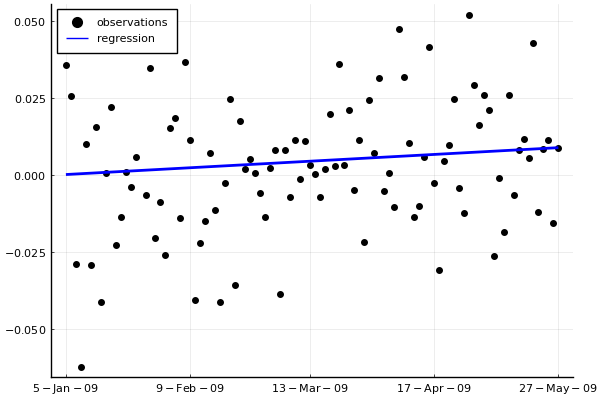

In [12]:
# Visualize observations
scatter(dates_num, stock_val, color="black", xticks=(xtick_points, [dates_str[i] for i in xtick_points]), label="observations", legend=:topleft)

# Overlay regression function
plot!(dates_num, regression_estimated, color="blue", label="regression", linewidth=2)

The slope coefficient $\theta_1$ is positive and the plot shows an increasing line. We may therefore conclude that the ISE has experienced a positive linear trend in the period January 2009 up to and including May 2009. If the stock market is indeed a good indicator of economic growth, then it is safe to say that the Turkish economy did grow in the first half of 2009.

---

### $\ast$ **Try for yourself**

Change the time period by setting the `num_samples` variable. Re-run the regression and see how the results change.

---

## Problem: Credit Assignment

We will now look at a classification problem. Suppose you are a bank and that you have to decide whether you will grant credit, i.e. a loan, to a customer. You have a historic data set where your experts have assigned credit to hundreds of people. You would like to automate this behavior.

### Data

The bank provides you with a training set of past credit assignments, labeled as succesful and failed (data pulled from [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Credit+Approval)). Many of the features have been anonymized for privacy concerns.

In [13]:
# Read CSV file
df = CSV.read("../datasets/credit_train.csv")

# Split dataframe into features and labels
features_train = convert(Array, df[:,1:7])
labels_train = convert(Array, df[:,8]);

# Store number of features
num_features = size(features_train,2)

# Number of training samples
num_train = size(features_train,1);

Let's visualize the data and see if we can make sense of it.

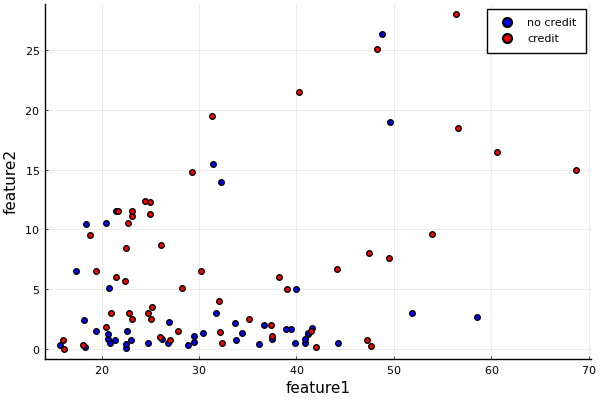

In [14]:
scatter(features_train[labels_train .== 0, 1], features_train[labels_train .== 0, 2], color="blue", label="no credit", xlabel="feature1", ylabel="feature2")
scatter!(features_train[labels_train .== 1, 1], features_train[labels_train .== 1, 2], color="red", label="credit")

Mmhh, it doesn't look like the samples can easily be separated. This will be challenging.

---

### $\ast$ **Try for yourself**

The plot above shows features 1 and 2. Have a look at the other combinations of features.

---

### Model specification

We have features $X$, labels $Y$ and parameters $\theta$. Again, we are looking for a joint distribution that splits into a likelihood and prior distributions:

$$\underbrace{p(\theta \mid Y, X)}_{\text{posterior}} \propto\ \underbrace{p(Y \mid X, \theta)}_{\text{likelihood}} \cdot \underbrace{p(\theta)}_{\text{prior}}$$

The likelihood in this case will be of a Logit form:

$$ p(Y \mid X, \theta) = \prod_{i=1}^{N} \ \text{Logit}(Y_i \mid f_\theta(X_i), \xi_i) \, .$$ 

A Logit is short for a Bernoulli distribution with a sigmoid transfer function: $ \sigma(x) = 1 / (1 + \exp(-x))$. The sigmoid maps the input to the interval $(0,1)$ so that the result acts as a rate parameter to the Bernoulli. The second parameter to the Logit $\xi$ is a "local variational parameter", which we won't go into here (see Section 10.5 of Bishop).

We will use a Gaussian prior distribution for the classification parameters $\theta$:

$$ p(\theta) = \mathcal{N}(\theta \mid \mu_\theta, \sigma^2_\theta) \, .$$

There is no conjugate prior for the Logit likelihood. However, ForneyLab will automatically approximate the true posterior with a Gaussian distribution.

In [15]:
import LinearAlgebra: I

In [16]:
# Start factor graph
graph = FactorGraph();

# Parameters for priors
μ_θ = zeros(num_features+1,)
σ2_θ = Matrix{Float64}(I, num_features+1, num_features+1)

# Define a prior over the weights
@RV θ ~ GaussianMeanVariance(μ_θ, σ2_θ)

X = Vector{Variable}(undef, num_train)
ξ = Vector{Variable}(undef, num_train)
Y = Vector{Variable}(undef, num_train)

for i = 1:num_train
    
    # Features
    @RV X[i]
    placeholder(X[i], :X, index=i, dims=(num_features+1,))
    
    # # Linear function
    @RV fθ = dot(θ, X[i])
    
    # Logit likelihood
    @RV ξ[i]
    @RV Y[i] ~ Logit(fθ, ξ[i])
    placeholder(Y[i], :Y, index=i)
    
end

We will now compile an inference algorithm for this model. However, in this classification problem, the samples are all _independently and identically distributed_ (iid). ForneyLab can't process them in sequence, but has to consider the entire data set at once. It will construct quite a large factor graph (too large to visualize) and it will take longer than usual to compile the algorithm.

In [17]:
# We specify a recognition distribution
q = PosteriorFactorization(θ, ξ, ids=[:θ, :ξ])

# Define and compile the algorithm
algorithm = messagePassingAlgorithm() 
source_code = algorithmSourceCode(algorithm)

# Evaluate the generated code to get the step! function
eval(Meta.parse(source_code));

Now that we have compiled the algorithm, we are going to iteratively update the classification parameters and the local variational parameter.

In [18]:
# Initialize posteriors
posteriors = Dict()
for i = 1:num_train
    posteriors[:ξ_*i] = ProbabilityDistribution(Function, mode=1.0)
end

# Load data
data = Dict(:X => [[features_train[i,:]; 1] for i in 1:num_train],
            :Y => labels_train)

# Iterate updates
@showprogress for i = 1:10
    
    # Update classification parameters
    stepθ!(data, posteriors)
    
     # Update local variational parameters
    stepξ!(data, posteriors)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


### Predict test data

The bank has some test data for you as well. 

In [19]:
# Read CSV file
df = CSV.read("../datasets/credit_test.csv")

# Split dataframe into features and labels
features_test = convert(Array, df[:,1:7])
labels_test = convert(Array, df[:,8])

# Number of test samples
num_test = size(features_test,1);

You can classify test samples by taking the Maximum A Posteriori for the classification parameters $\theta_{\text{MAP}}$, computing the linear function $f_\theta$ and rounding the result to obtain the most probable label.

In [20]:
import ForneyLab: unsafeMode

In [21]:
# Extract MAP estimate of classification parameters
θ_MAP = unsafeMode(posteriors[:θ])

# Compute linear product between parameters and test data
fθ_pred = [features_test ones(num_test,)] * θ_MAP

# Predict labels
labels_pred = round.(1 ./(1 .+ exp.( -fθ_pred)));

# Compute classification error of test data
accuracy_test = mean(labels_test .== labels_pred)

# Report result
println("Test Accuracy = "*string(accuracy_test*100)*"%")

Test Accuracy = 63.0%


Mmmhh... If you were a bank, you might decide that you don't want to automatically assign credit to your customers.